Purpose: tracklets and bounding boxes are in one place after extracting the .gz file written during the tacking session. Now, we run keypoint inference on the input video using the tracklets we have extracted.

In [1]:
import json
from sparrow_datums import Boxes
import numpy as np
import imageio
from tqdm import tqdm
import cv2
import os
from pathlib import Path
import matplotlib.pyplot as plt
from typing import Optional
import io
# import torch

In [2]:
from speed_trapv3.keypoints.model import SegmentationModel
from speed_trapv3.keypoints.config import Config as KeyConfig
from sparrow_datums import AugmentedBoxTracking, BoxTracking, FrameBoxes, PType
from speed_trapv3.keypoints.dataset import crop_and_resize,process_keypoints, keypoints_post_inference_processing
from speed_trapv3.tracking.tracking import get_video_properties, transform_image, write_to_json

/usr/local/lib/python3.9/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
video_path = "/code/data/datasets/common_hall/source_video/25_resampled_vid.mp4"
save_path = '/code/data/datasets/common_hall/tracking_inference_frame_lib/hard_coded_video2.mp4'
gz_path = '/code/data/datasets/tracking/predictions/hard_coded/hard_coded_vehicle.json.gz'

In [4]:
# ! rm -rf /code/data/datasets/common_hall/tracking_inference_frame_lib/*

In [5]:
# fps, n_frames = get_video_properties(video_path)
# reader = imageio.get_reader(video_path)
# slug = "hard_coded"
# for i in tqdm(range(n_frames)):
#     img = reader.get_data(i)
#     img = cv2.rectangle(
#         img, (450, 200), (1280, 720), thickness=5, color=(0, 255, 0))
#     filename = str(i) + ".jpg"
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     cv2.imwrite(os.path.join(save_path, filename), img)

In [6]:
keypoint_model = SegmentationModel().eval().cuda()
keypoint_model.load(KeyConfig.trained_model_path)

<All keys matched successfully>

In [7]:
# f = open('/code/data/datasets/tracking/predictions/hard_coded_vehicle.json')
# data = json.load(f)
# for obj in data['annotations']:
#     obj_id = obj['id']
#     frame_start, frame_end = obj['segments'][0]
#     boxes = obj['frames']
#     for frame_idx in range(frame_start, frame_end):
#             # img = imageio.imread(Path(save_path)/f'{frame_idx}.jpg')
#             img = cv2.imread(str(Path(save_path)/f'{frame_idx}.jpg'))
#             box = boxes[str(frame_idx)]['bounding_box']
#             x = box['x']
#             y = box['y']
#             w = box['w']
#             h = box['h']
#             box = Boxes([x, y, w, h]).to_tlbr()
#             x1, y1, x2, y2 = box
#             roi_w = x2 - x1
#             roi_h = y2 - y1
#             roi_resized = crop_and_resize(box, img, KeyConfig.image_crop_size[0],KeyConfig.image_crop_size[1])
#             roi_resized_w, roi_resized_h = roi_resized.size
#             # x = image_transform(roi_resized)
#             # x = torch.unsqueeze(x, 0).cuda()
#             # keypoints = keypoint_model(x)['keypoints'][0].detach().cpu().numpy()
#             keypoints = keypoint_model(roi_resized)
#             keypoints = keypoints_post_inference_processing(
#                 keypoints, roi_resized_w, roi_resized_h, roi_w, roi_h, x1, y1
#             )

599it [00:02, 227.49it/s]


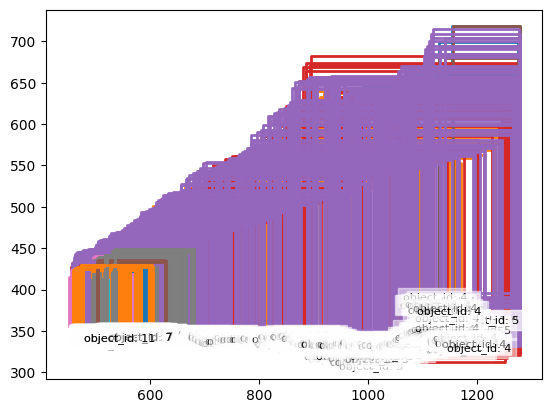

In [8]:
reader = imageio.get_reader(video_path)
fps = reader.get_meta_data()["fps"]
class_label: bool = False
score_label: bool = False
object_label: bool = True
vehicle_chunk = AugmentedBoxTracking.from_box_tracking(
    BoxTracking.from_file(gz_path)
)
# if vehicle_chunk.fps != fps:
#     vehicle_chunk = vehicle_chunk.resample(fps)
with imageio.get_writer(
    save_path, mode="I", fps=fps, macro_block_size=None
) as writer:
    aggregated_predictions = [] #Len is equal to to the number of frames.
    frame_idx = 0
    for img, vehicle_boxes in tqdm(zip(reader, vehicle_chunk)):
        frame_log = {}
        frame_log['frame_idx'] = frame_idx
        frame_log['annotations'] = []
        # boxes = list(vehicle_boxes)
        boxes = vehicle_boxes  # vehicle_boxes is a len = 16 list where unavailable objects are nan.
        # result = plot_boxes(img, boxes, object_label=True)
        height, width = img.shape[:2]
        # fig = plt.figure(frameon=False, figsize=(width / 100, height / 100), dpi=100)
        # fig.add_axes((0, 0, 1, 1))
        # plt.imshow(img)
        # for boxes in tqdm(boxes_in):
        #     print("Madona says boxes", boxes)
        for i, box in enumerate(boxes.to_absolute()):
            object_log = {}
            # for i, box in enumerate(boxes.to_absolute()):
            if not np.isfinite(box.x):
                continue
            x1 = np.clip(box.x1, 2, width - 2)
            x2 = np.clip(box.x2, 2, width - 2)
            y1 = np.clip(box.y1, 2, height - 2)
            y2 = np.clip(box.y2, 2, height - 2)
            color: Optional[str] = None
            text_strings: list[str] = []
            if class_label:
                text_strings.append(f"class: {int(box.label)}")
                color = f"C{int(box.label)}"
            if score_label:
                text_strings.append(f"score: {box.score:.2f}")
            if object_label:
                text_strings.append(f"object_id: {i}")
                if color is None:
                    color = f"C{i}"
            if color is None:
                color = "C0"
            plt.text(
                x1 + 3,
                y1 - 8,
                ", ".join(text_strings),
                backgroundcolor=(1, 1, 1, 0.5),
                c="black",
                size=8,
            )
            plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], lw=2, c=color)
            object_log['object_id'] = i
            object_log['bounding_box'] = list(box.array[:4])
            frame_log["annotations"].append(object_log)
        aggregated_predictions.append(frame_log)
        frame_idx += 1
        buffer = io.BytesIO()
        # plt.savefig(buffer, format="png")
        # plt.close()
        # frame = imageio.v2.imread(buffer.getbuffer(), format="png")
        # writer.append_data(frame)
    out_file = open("/code/data/datasets/common_hall/tracking_output_videos/myfile.json", "w")
    json.dump(aggregated_predictions, out_file)
    out_file.close()